In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs

In [75]:
DATA_PATH = "../Project/Dataset/"

<font color = 'red'> Generally what we do in the notebook

### Data load

In [86]:
timeseries_df = pd.read_csv(f"{DATA_PATH}df_timeseries_with_sudden_growth_merged.tsv.gz", sep='\t', compression='gzip', parse_dates=["datetime"])
timeseries_df.head(2)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,growth_rate,max_views_difference
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,202494.555556,0.000000,650.222222,0.000000,5,0,3,NaN,NaN
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,394085.666667,191591.111111,1046.000000,395.777778,6,1,1,NaN,NaN


In [87]:
channel_df = pd.read_csv(f"{DATA_PATH}df_channels_en.tsv.gz", sep='\t', compression='gzip', parse_dates=["join_date"])
channel_df.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087


## Initial filtering

<font color = 'red'> **TO DO** </font>  
The "timeseries_df" is further filtered to obtain the exact data of interest. First of all, ????  
Secondly, we used the "growth_rate" metric we defined earlier to detect the date of maximum growth ("max_growth_date") of each channel by observing when the value of the parameter was the highest. Then, an observation timespan of 6 months around this date was selected for every channel (12 weeks before and 14 after the maximum growth) to be able to make robust and relevant comparisons between them.  
Afterwards, also the `channel_df` dataframe was filtered to keep only the channels remaining in the `timeseries_df`.  

In [88]:
#remove channels with growth steepness NaN
allna = timeseries_df["growth_rate"].isna().groupby(timeseries_df["channel"]).all()
channels_to_filter = allna[allna].index
timeseries_df = timeseries_df[~(timeseries_df["channel"].isin(channels_to_filter))]

In [89]:
# get max growth date for each channel
timeseries_df = timeseries_df.reset_index(drop=True)
idx = timeseries_df.groupby("channel")["growth_rate"].idxmax()
datetimes = timeseries_df.loc[idx][["datetime", "channel", "views"]].rename(columns={"datetime": "max_growth_date", "views": "max_growth_views"})
datetimes = datetimes.reset_index().rename(columns={"index": "max_growth_index"})
datetimes.head(2)

,max_growth_index,max_growth_date,channel,max_growth_views
0,1895571,2018-06-25 00:00:00,UC--24Q3_ZQeFmgJE-Um5QZQ,1497153.0
1,16647234,2017-01-15 23:00:00,UC--2EbuIuBOGgGqPiJxi3rg,3539309.0


In [90]:
# get the 6 month timespan around the max growth date
timeseries_df_with_max_growth = timeseries_df.merge(datetimes, on="channel")
timeseries_df_with_max_growth = timeseries_df_with_max_growth[(
      (timeseries_df_with_max_growth.index >= timeseries_df_with_max_growth["max_growth_index"] - 12) 
    & (timeseries_df_with_max_growth.index <= timeseries_df_with_max_growth["max_growth_index"] + 14)
)]
timeseries_df_with_max_growth

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,growth_rate,max_views_difference,max_growth_index,max_growth_date,max_growth_views
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1,NaN,NaN,13,2017-10-02 00:00:00,6.597325e+06
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1,NaN,NaN,13,2017-10-02 00:00:00,6.597325e+06
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0,NaN,NaN,13,2017-10-02 00:00:00,6.597325e+06
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0,NaN,NaN,13,2017-10-02 00:00:00,6.597325e+06
5,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-08-07,1.493380e+06,208974.200000,2270.200000,261.900000,6,0,0,NaN,NaN,13,2017-10-02 00:00:00,6.597325e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18553888,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-05-27,2.636709e+06,230024.052632,38840.421053,1887.052632,176,14,31,0.000000,3.710902e+06,18553878,2019-03-17 23:00:00,7.109077e+05
18553889,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-06-03,2.868836e+06,232126.578947,40355.600000,1515.178947,189,13,30,0.000086,3.710902e+06,18553878,2019-03-17 23:00:00,7.109077e+05
18553890,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-06-10,3.134622e+06,265786.214286,42404.642857,2049.042857,201,12,28,0.001466,3.710902e+06,18553878,2019-03-17 23:00:00,7.109077e+05
18553891,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-06-17,3.444821e+06,310198.500000,45248.142857,2843.500000,210,9,25,0.003462,3.710902e+06,18553878,2019-03-17 23:00:00,7.109077e+05


In [91]:
timeseries_df = timeseries_df_with_max_growth.copy()

In [92]:
# channel filtering with only the selected channels
channel_df = channel_df[channel_df["channel"].isin(timeseries_df["channel"].unique())]

## Addition of new columns for future analysis 
* **cumulative views**: sum of the views gained each week with the ones obtained in the previous ones, throughout the observation period
* **delta views**: difference between the views gained each week and the ones obtained in the previous one. We note that this feature is already present in the original dataset, however the absolute values are given. For our analysis the negative sign due to drop in views has relevant significance, therefore we restore it. 


In [93]:
ts_grouped_by_channel = timeseries_df.groupby('channel')

# calculate cumulative views per channel
timeseries_df["cumviews"] = ts_grouped_by_channel["views"].cumsum()

# because negative delta views are not included in the original dataset, we recalculated them
timeseries_df["delta_views"] = ts_grouped_by_channel["views"].diff().fillna(0)

In [95]:
timeseries_df.head(2)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,growth_rate,max_views_difference,max_growth_index,max_growth_date,max_growth_views,cumviews
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,394085.666667,0.000000,1046.0,395.777778,6,1,1,NaN,NaN,13,2017-10-02,6597324.75,3.940857e+05
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,835393.750000,441308.083333,1501.5,455.500000,6,0,1,NaN,NaN,13,2017-10-02,6597324.75,1.229479e+06


## Significative channels visualization

#### Sudden success followed by downfall

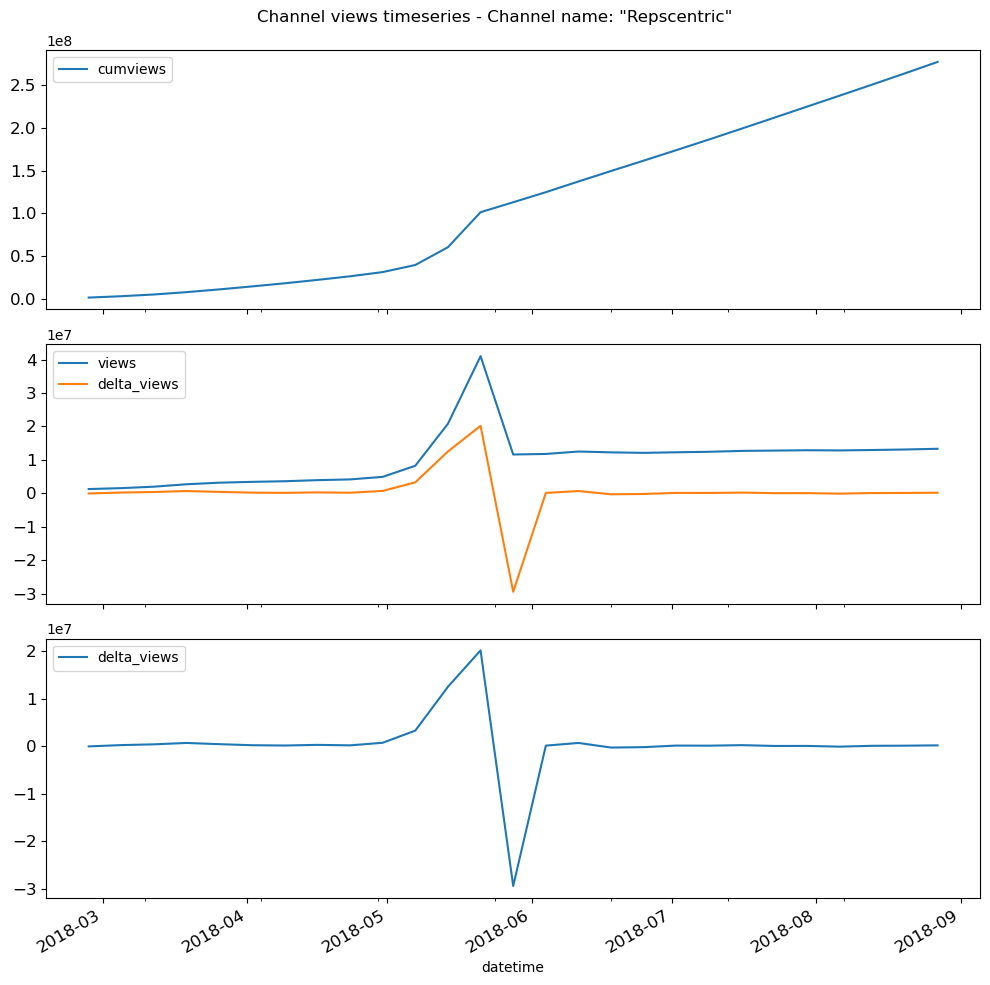

In [12]:
current_channel = 'UCj-R_ePoJvWGiLOD6aDgMSg'

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs_flat = axs.ravel()

fig.suptitle(f"Channel views timeseries - Channel name: \"{channel_df[channel_df['channel'] == current_channel]['name_cc'].iloc[0]}\"")

timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="cumviews", ax=axs_flat[0], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[2], fontsize=12)

for i in range(3):
    axs_flat[i].legend(loc='upper left')
plt.tight_layout()

This channel is an example of a 'lose-fame' channel. We can observe that it experienced a steep growth in a relatively short period of time (less than two months), but it lost the gained views right after. Indeed, a peak in the ‘delta_views’ followed is visible, but it is followed by a sudden decrease; also, at the beginning and at the end of the observation period, the views don’t show a big variation.


#### Sudden success followed by stability

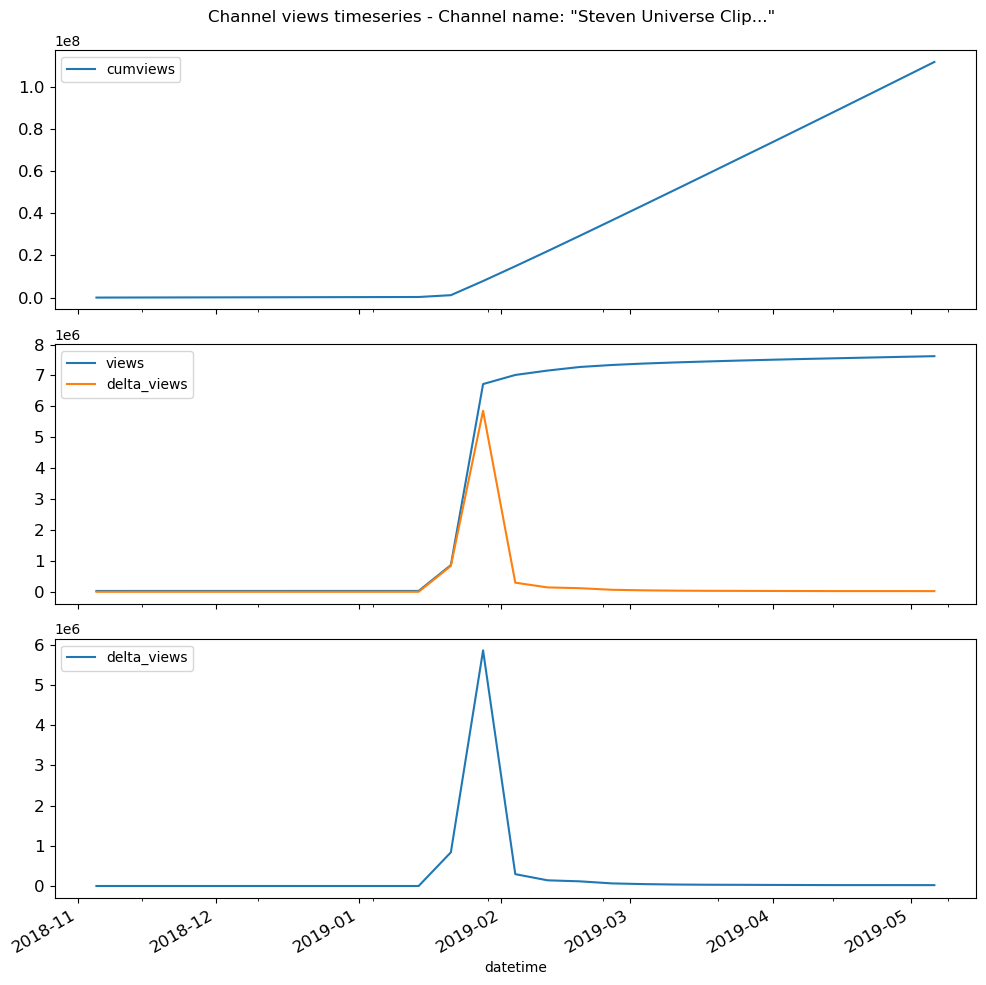

In [13]:
current_channel = 'UCa4hfBXGDC_TxUHTEbCdyng'

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs_flat = axs.ravel()

fig.suptitle(f"Channel views timeseries - Channel name: \"{channel_df[channel_df['channel'] == current_channel]['name_cc'].iloc[0]}\"")

timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="cumviews", ax=axs_flat[0], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[2], fontsize=12)

for i in range(3):
    axs_flat[i].legend(loc='upper left')
plt.tight_layout()

These graphs well represent the ‘keep-fame’ population. Indeed, we can observe that, after the spike in weekly views, the channel's popularity in terms of visualizations has stabilized. It keeps having high numbers of views, significantly larger than before sudden success gain. This can also be underlined by the fact that the number of views between the beginning and the end of the time series has significantly increased.

## Population division

### Step 1: Calculate meaningful metrics

##### Metric 1: Channel growth
<font color = 'red'> CONTROLLARE soprattutto definizione dipeak views </font>  
This metric is used as a first step to distinguish between the populations of who lost and who gained fame after sudden success. It consists of the variation of views from the end and the beginning of the observation period considered, normalized by the difference between the peak views (corresponding to those obtained at the date of maximum growth rate) and the views at the beginning. It displays if the channel gained or lost views, or if they remained more or less contant, and it compares this value to the overall success the channel had (i.e. to what extent did the channel grow over the observation period compared to the maximum variation of views it had within the same period?).

In [14]:
begin, end = ts_grouped_by_channel['views'].first(), ts_grouped_by_channel['views'].last()
peak = ts_grouped_by_channel['max_growth_views'].max()

growth = (end - begin) / (peak - begin)
growth.head(2)

channel
UC--24Q3_ZQeFmgJE-Um5QZQ    1.507606
UC--2EbuIuBOGgGqPiJxi3rg    2.288127
dtype: float64

#### Metric 2: Views variability 
This metric is an indicator of the variability of the views during the observation period per channel, giving insights about the relative extent to which the visualizations varied. It is computed by making the difference between the maximum and minimum number of views, normalized with respect to the maximum.

In [15]:
max_views = ts_grouped_by_channel['views'].max()
min_views = ts_grouped_by_channel['views'].min()

variability = (max_views - min_views) / max_views
variability.head(2)

channel
UC--24Q3_ZQeFmgJE-Um5QZQ    0.777823
UC--2EbuIuBOGgGqPiJxi3rg    0.181075
Name: views, dtype: float64

##### Metric 3: Views growth steepness
This is a metric obtained from the maximum number of new views gained in a week with respect to the week before, divided by the maximum number of views overall. It allows to detect if the growth was steep (in other words, if the newly gained views had a significant impact on the overall views), by comparing the orders of magnitude of the two quantities.

In [16]:
delta_max = ts_grouped_by_channel["delta_views"].max()

growth_steepness = delta_max / max_views
growth_steepness.head(2)

channel
UC--24Q3_ZQeFmgJE-Um5QZQ    0.373151
UC--2EbuIuBOGgGqPiJxi3rg    0.015322
dtype: float64

In [17]:
metrics = pd.DataFrame({
    "growth_steepness": growth_steepness,
    "growth": growth,
    "variability": variability
}).reset_index()
metrics.head(2)

,channel,growth_steepness,growth,variability
0,UC--24Q3_ZQeFmgJE-Um5QZQ,0.373151,1.507606,0.777823
1,UC--2EbuIuBOGgGqPiJxi3rg,0.015322,2.288127,0.181075


In [18]:
# merge metrics in the original channel dataframe

channel_df = channel_df.merge(metrics, on="channel")
channel_df = channel_df.merge(timeseries_df.loc[idx][["growth_rate", "channel"]], on="channel")
channel_df.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,growth_rate
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087,0.014809,1.600348,0.097973,0.000282
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087,0.026932,2.777922,0.534130,0.000534


### Step 2: Furter channel filtering 
In this step we filtered out more channels that would not be representative of the populations we want to study.  
Firstly, we removed all the channels that don't have a high enough "growth_rate" which we identified by putting a threshold of 0.15. This allowed us to select only the channels that had sudden success and that are of interest in our analysis.  
Furthermore, we removed all the channels that experienced a steep decrease before the sudden increase. An example of these channels is shown in the cell below, where it is cleat that the fast growht in views of the channel only allowed it to regain the views that he already had but had once lost. For this step we compared the minimum value of "growth-rate" with the maximum value, and if it was higher than 0.5 (more than 50% of views gained later were actually lost before) we discarded the channel. 

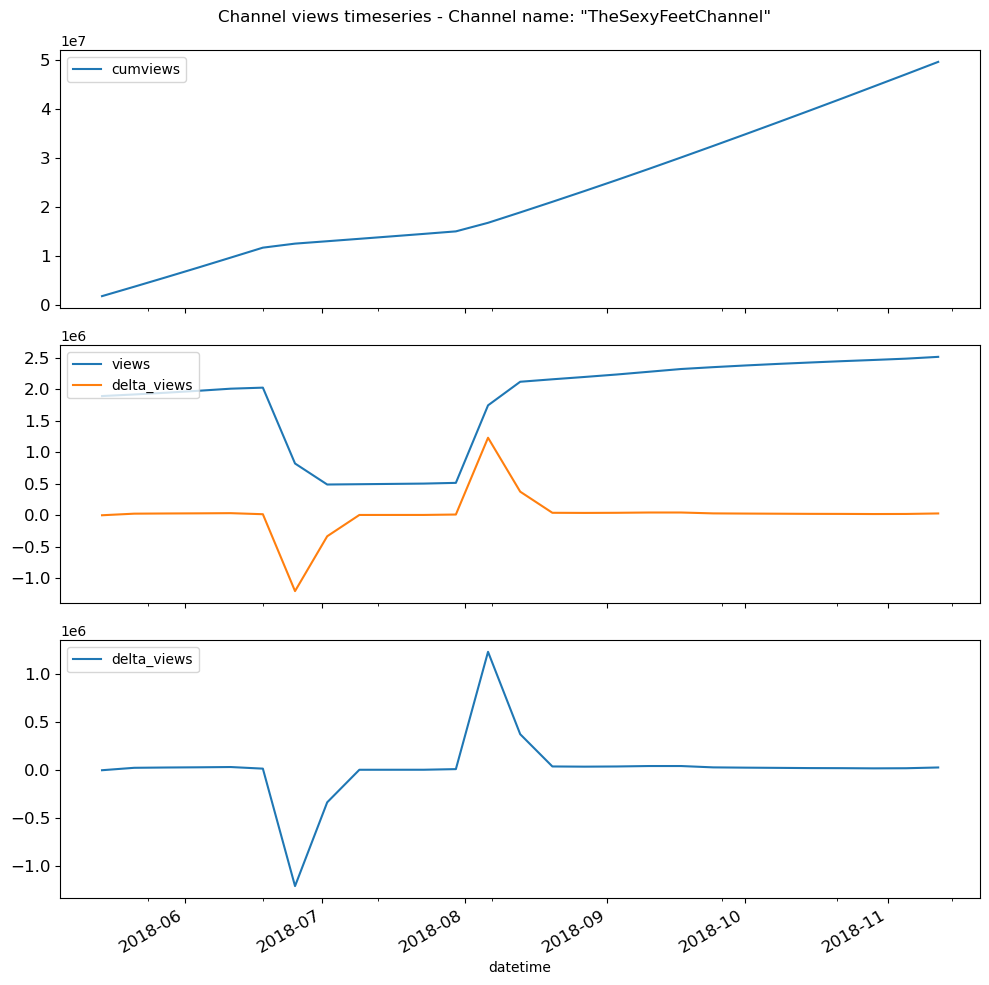

In [19]:
current_channel = 'UCPUz_yix50KLCxpmbE9fOrQ'

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs_flat = axs.ravel()

fig.suptitle(f"Channel views timeseries - Channel name: \"{channel_df[channel_df['channel'] == current_channel]['name_cc'].iloc[0]}\"")

timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="cumviews", ax=axs_flat[0], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[2], fontsize=12)

for i in range(3):
    axs_flat[i].legend(loc='upper left')
plt.tight_layout()

In [20]:
# filter channels that grow rapidly enough

sudden_growth_bound = 0.15
channel_df_filtered = channel_df[channel_df["growth_rate"] > sudden_growth_bound]
timeseries_df_filtered = timeseries_df[timeseries_df["channel"].isin(channel_df_filtered["channel"])]

In [21]:
# calculate the steepness of the decrease before the peak increase
min_growth_steepness_per_channel_before_peak = (
    timeseries_df_filtered
        .reset_index()
        .groupby('channel')
        .apply(lambda group: group.iloc[:12])
        .set_index("index")
        .groupby('channel')["growth_rate"]
        .min()
)

# filter channels with a steep decrease before the peak
thr_decrease = -0.5
decrease_bf_growth = min_growth_steepness_per_channel_before_peak/channel_df_filtered.set_index("channel")["growth_rate"] 
channels_to_filter = decrease_bf_growth[decrease_bf_growth < thr_decrease].index

# apply the filter
channel_df_filtered = channel_df_filtered[~channel_df_filtered["channel"].isin(channels_to_filter)]
timeseries_df_filtered = timeseries_df_filtered[~timeseries_df_filtered["channel"].isin(channels_to_filter)]

In [59]:
timeseries_df_filtered.to_csv("timeseries_df_filtered.tsv.gz", sep="\t", compression="gzip")

### Step 3: Divide population using the metrics
<font color="red">CONTROLLARE</font>  
As a third step, to identigy the two populations, the first metric (“channel growth”) is employed. Having defined a threshold of 0.6, we attribute all the channels that have values lower that 0.6 to the ‘lose_fame’ group, as this indicated that, overall, they lost at least 40% of views that they had gained.  Channels who instead showed a “channel growth” above 0.6, were assigned to the ‘keep_fame’ dataframe, since they significantly increased their popularity.

In [22]:
growth_bound = 0.6

# TODO: fix comment. select channels with a growth 
lose_fame = channel_df_filtered[(channel_df_filtered["growth"] <= growth_bound)]
lose_fame_ts = timeseries_df_filtered[timeseries_df_filtered["channel"].isin(lose_fame["channel"])]

# TODO: fix comment. keep only channels with  
keep_fame = channel_df_filtered[(channel_df_filtered["growth"] > growth_bound)]
keep_fame_ts = timeseries_df_filtered[timeseries_df_filtered["channel"].isin(keep_fame["channel"])]

In [23]:
keep_fame.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,growth_rate
2409,People & Blogs,2016-12-20,UCFYKs_0xpOB3YnpyfbwuSZQ,Noah Schnapp,2060000,11,5279.0,2.388,0.161097,14.783459,0.998207,0.349038
3198,Entertainment,2014-07-22,UCFs9b_YD0JNvBHYdJFA-Q1A,MTV Shores,1730000,805,7290.0,2.539,0.499723,1.718115,0.874593,0.204596


In [24]:
lose_fame.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,growth_rate
1101,Education,2012-07-06,UCWKeZvw4iSZVM2qXKZde58A,Zee Kids,4036073,190,2218.0,2.141,0.596482,0.434900,0.700533,0.225176
3845,Music,2006-05-09,UCHF66aWLOxBW4l6VkSrS3cQ,Coachella,1630000,247,9075.0,2.544,0.704501,0.042419,0.807842,0.336620


### Step 4: Last filtering of the channels for the "keep_fame" population
The last step of the preprocessing to identify the two groups of interest, was the final filtering of the "keep_fame" population.  
Indeed, some of the channels identified with our pipeline in this case showed a sudden peak of fame, a loss in views right after, and then a slow growth (example shown in the figure in the cell below). These channels shouldn't be assigned to the population because the success wasn't really kept after the sudden gain of views, but was gradually obtained in later times, therefore they had to be filtered out from the group. To do so, we checked if the variation of the minimum views value after the peak with respect to the value at the beginning of the observation, normalized by the difference between the peak views (corresponding to those obtained at the date of maximum growth rate) and the views at the beginning. If this value was below the already used threshold for the "growth channel" metric of 0.15 ("sudden_growth_bound"), we discarded the channel.

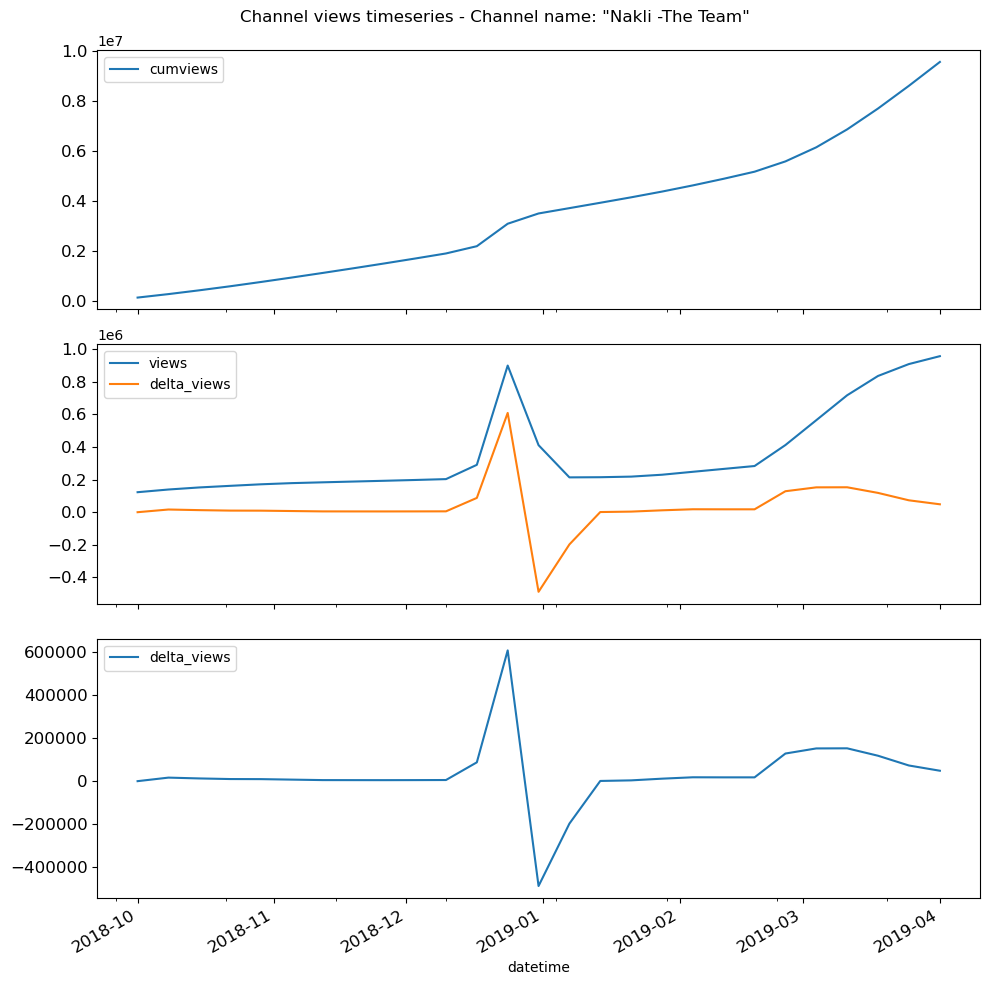

In [25]:
current_channel = 'UCnzZH_Mnuk6pMt8V-tK3gqg'

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs_flat = axs.ravel()

fig.suptitle(f"Channel views timeseries - Channel name: \"{channel_df[channel_df['channel'] == current_channel]['name_cc'].iloc[0]}\"")

timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="cumviews", ax=axs_flat[0], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[2], fontsize=12)

for i in range(3):
    axs_flat[i].legend(loc='upper left')
plt.tight_layout()

In [26]:
# pick the minimum views after the peak (if the min is below the threshold, the channel is considered to have lost fame)
min_views_per_channel_after_peak = (
    keep_fame_ts
        .reset_index()
        .groupby('channel')
        .apply(lambda group: group.iloc[13:])
        .set_index("index")
        .groupby('channel')["views"]
        .min()
)

# calculate the relative drop in views after the peak
keep_ts_grouped_by_channel = keep_fame_ts.groupby('channel')
begin = keep_ts_grouped_by_channel['views'].first()
peak = keep_ts_grouped_by_channel['max_growth_views'].max()
minimum = min_views_per_channel_after_peak
relative_drop = (minimum - begin) / (peak - begin)

# filter out channels that have lost too much fame
channels_to_filter = relative_drop[relative_drop < sudden_growth_bound]
keep_fame = keep_fame[~keep_fame["channel"].isin(channels_to_filter.index)]
keep_fame_ts = keep_fame_ts[~keep_fame_ts["channel"].isin(channels_to_filter.index)]

#### Statistics of the final populations

In [27]:
keep_fame.describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,growth_rate
count,1.059000e+03,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,7.561529e+04,400.666667,434055.811143,8.964067,0.344024,5.317299,0.924842,0.248161
std,1.421807e+05,4579.630832,274947.795854,7.799021,0.149072,79.289031,0.100222,0.099891
min,1.000000e+04,10.000000,5279.000000,2.388000,0.074595,0.637771,0.464527,0.150075
25%,1.550000e+04,31.500000,180851.000000,5.235000,0.241603,1.310507,0.896454,0.175482
50%,2.840000e+04,68.000000,399283.000000,7.422000,0.320033,1.770276,0.968570,0.215915
75%,7.704200e+04,149.500000,662526.000000,10.093250,0.429022,2.637953,0.993436,0.289696
max,2.060000e+06,104712.000000,993334.000000,53.143500,0.825418,2576.981448,1.000000,0.796650


In [28]:
lose_fame.describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,growth_rate
count,7.500000e+01,75.00000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,1.798928e+05,1543.12000,386372.413333,8.041193,0.442822,-0.571884,0.827766,0.255868
std,5.074935e+05,11990.00751,301424.534766,6.668374,0.132913,4.096279,0.121437,0.103472
min,1.000000e+04,11.00000,2218.000000,2.141000,0.161316,-23.808532,0.480619,0.151388
25%,1.715000e+04,29.50000,119540.000000,4.206000,0.347302,0.102905,0.754554,0.180535
50%,3.550000e+04,78.00000,359705.000000,6.063000,0.420054,0.294617,0.814550,0.219837
75%,1.378495e+05,166.50000,643195.000000,10.555250,0.524370,0.466915,0.924627,0.325595
max,4.036073e+06,103973.00000,961077.000000,53.143500,0.815045,0.592890,0.999827,0.627129


### Step 5: Propensity scores
Having defined the two population and having removed all the examples that could have biased our experiment, we were now able to perform propensity score matching. We computed the propensity scores through logistic regression, using as regressors all the columns (after standardization) of the "lose_fame" and "keep_fame" dataframes except "subscribers_cc", "videos_cc", "subscriber_rank_sb", "weights", "growth_rate", "variability", "growth_steepness". Moreover, we converted the categorical variables into dummy indicators for the logistic model. After the regression, we added the propensity scores to the identified populations, and we performed matching.

In [29]:
lose_fame = lose_fame.copy()
keep_fame = keep_fame.copy()
lose_fame["keep_fame"] = 0
keep_fame["keep_fame"] = 1

In [30]:
print(f"lose_fame population size: {lose_fame.shape[0]:4d}")
print(f"keep_fame population size: {keep_fame.shape[0]:4d}")

lose_fame population size:   75
keep_fame population size: 1059


In [31]:
# exclude categories that are not in the intersection of the two sets from the regressors of the propensity score because they can separate the data perfectly
common_categories = set.intersection(set(lose_fame["category_cc"].unique().tolist()), set(keep_fame["category_cc"].unique().tolist()))
common_categories = pd.Series(list(common_categories)).str.replace(" & ", "_").str.replace(" ", "_")
display(common_categories)

# and apply the string transformation to the category column
channels_filtered_df = pd.concat([lose_fame, keep_fame])
channels_filtered_df["category_cc"] = channels_filtered_df["category_cc"].str.replace(" & ", "_").str.replace(" ", "_")
channels_filtered_df.head(2)

0                  Music
1           People_Blogs
2                 Gaming
3                 Comedy
4              Education
5         Autos_Vehicles
6                 Sports
7           Pets_Animals
8          Entertainment
9     Film_and_Animation
10           Howto_Style
11    Science_Technology
dtype: object

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,growth_rate,keep_fame
1101,Education,2012-07-06,UCWKeZvw4iSZVM2qXKZde58A,Zee Kids,4036073,190,2218.0,2.141,0.596482,0.434900,0.700533,0.225176,0
3845,Music,2006-05-09,UCHF66aWLOxBW4l6VkSrS3cQ,Coachella,1630000,247,9075.0,2.544,0.704501,0.042419,0.807842,0.336620,0


In [32]:
# pick the columns we use as regressors
regressors_cols = ["subscribers_cc", "videos_cc", "subscriber_rank_sb", "weights", "growth_rate", "variability", "growth_steepness"]

# standardize the regressors
channels_filtered_df[regressors_cols] = channels_filtered_df[regressors_cols] - channels_filtered_df[regressors_cols].mean()
channels_filtered_df[regressors_cols] = channels_filtered_df[regressors_cols] / channels_filtered_df[regressors_cols].std()

# add the category column dummies
channels_filtered_df = pd.get_dummies(channels_filtered_df, columns=["category_cc"], dtype=int)

In [33]:
# preview thd data that will be used for the propensity score
categories = common_categories.apply(lambda x: f"category_cc_{x}").to_list()
channels_filtered_df[regressors_cols + categories].describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_rate,variability,growth_steepness,category_cc_Music,category_cc_People_Blogs,category_cc_Gaming,category_cc_Comedy,category_cc_Education,category_cc_Autos_Vehicles,category_cc_Sports,category_cc_Pets_Animals,category_cc_Entertainment,category_cc_Film_and_Animation,category_cc_Howto_Style,category_cc_Science_Technology
count,1.134000e+03,1.134000e+03,1.134000e+03,1.134000e+03,1.134000e+03,1.134000e+03,1.134000e+03,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000
mean,1.669740e-16,-2.921189e-17,2.627724e-16,9.633681e-16,-2.860929e-15,7.618832e-15,1.524256e-15,0.105820,0.158730,0.227513,0.053792,0.032628,0.021164,0.025573,0.005291,0.211640,0.054674,0.051146,0.022928
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.307743,0.365585,0.419412,0.225706,0.177739,0.143994,0.157928,0.072579,0.408651,0.227443,0.220393,0.149739
min,-3.802184e-01,-8.649421e-02,-1.548223e+00,-8.747597e-01,-9.849359e-01,-4.342501e+00,-1.839397e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.513580e-01,-8.259829e-02,-9.123106e-01,-4.820931e-01,-7.291027e-01,-3.958755e-01,-6.752280e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.808535e-01,-7.554853e-02,-1.277924e-01,-1.976713e-01,-3.247518e-01,4.505279e-01,-1.505252e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-5.164592e-03,-6.052141e-02,8.365388e-01,1.571081e-01,4.163995e-01,7.111508e-01,5.855162e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.073061e+01,1.933782e+01,2.031263e+00,5.723101e+00,5.474164e+00,7.804731e-01,3.165117e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
import statsmodels.formula.api as smf

regressors = str.join(' + ', regressors_cols + categories)
res = (
    smf
        .logit(formula=f"""keep_fame ~ {regressors}""", data=channels_filtered_df)
        .fit(maxiter=100000, method='bfgs')
)

propensity_score = res.predict()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.201491
         Iterations: 162
         Function evaluations: 164
         Gradient evaluations: 164
                           Logit Regression Results                           
Dep. Variable:              keep_fame   No. Observations:                 1134
Model:                          Logit   Df Residuals:                     1114
Method:                           MLE   Df Model:                           19
Date:                Wed, 21 Dec 2022   Pseudo R-squ.:                  0.1726
Time:                        18:23:46   Log-Likelihood:                -228.49
converged:                       True   LL-Null:                       -276.16
Covariance Type:            nonrobust   LLR p-value:                 3.694e-12
                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

<font color = 'red'> interpretation and visualization? </font>

In [35]:
# add the propensity score to the two populations
keep_fame["propensity_score"] = propensity_score[channels_filtered_df["keep_fame"] == 1]
lose_fame["propensity_score"] = propensity_score[channels_filtered_df["keep_fame"] == 0]
display(keep_fame.sort_values("propensity_score", ascending=False).head(2))
display(lose_fame.sort_values("propensity_score", ascending=False).head(2))

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,growth_rate,keep_fame,propensity_score
25081,Nonprofits & Activism,2017-01-04,UCFwWNI5kT27ZwOTkxaZ86hw,Rahe Insaniyat Offic...,151000,250,84359.0,4.3325,0.111039,8.928789,0.996810,0.298706,1,0.999997
99076,Travel & Events,2017-05-07,UCjryOxVyc8bP8PvZRNGClnQ,Walid Fatam,16900,37,634109.0,9.9530,0.183366,2.144344,0.998675,0.171862,1,0.999997


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,growth_rate,keep_fame,propensity_score
122688,Gaming,2018-02-25,UCcEWKT3bmBENciUiAKDjIOQ,Zuriel Vlog,10300,83,961077.0,53.1435,0.326785,0.397180,0.990233,0.287966,0,0.986660
34137,People & Blogs,2017-09-07,UCj-R_ePoJvWGiLOD6aDgMSg,Repscentric,138699,33,125823.0,3.9800,0.492513,0.303075,0.967782,0.352864,0,0.982823


### Step 6: Matching
To be able to conduct our observational study, we matched the two populations. We used the propensity scores to match each data point from the "keep_fame" group with exactly one data point from the "lose_fame" one, while ensuring that each data point from one population was matched with at most one data point from the other. The matching process maximized the similarity between channel, which was defined as:
$$ similarity(keep\_channel,lose\_channel) = 1 - | propensity\_score(keep\_channel) - propensity\_score(lose\_channel) |$$  
After matching, 75 channels for each population were identified, and on those channels we will focus our future analyses.

In [45]:
pairs = keep_fame[["channel", "propensity_score"]].merge(lose_fame[["channel", "propensity_score"]], how="cross", suffixes=["_keep", "_lose"])
pairs["similarity"] = 1 - np.abs(pairs["propensity_score_keep"] - pairs["propensity_score_lose"])
pairs.sort_values("similarity", ascending=False).head(2)

,channel_keep,propensity_score_keep,channel_lose,propensity_score_lose,similarity
1358,UC3EOz7Jz1W3eCOdaROqtrlA,0.970898,UCfEkmFv0YZ870a5o205WpsQ,0.970894,0.999996
18594,UC3NAMaMH0UGSnfqVoOp6EHA,0.955836,UCwE_D5ZNbtrTPKEa1Z9fQgw,0.955841,0.999996


In [46]:
import networkx as nx

edges = list(pairs[["channel_keep", "channel_lose", "similarity"]].itertuples(index=False, name=None))

graph = nx.Graph()
graph.add_weighted_edges_from(edges)
matched_pairs = nx.max_weight_matching(graph)

In [50]:
list_matched_data = [i[0] for i in list(matched_pairs)] + [i[1] for i in list(matched_pairs)]
matched_df = pd.DataFrame()
matched_df['channel_keep'] = [i for i in list_matched_data if i in keep_fame['channel'].tolist()]
matched_df['channel_lose'] = [i for i in list_matched_data if i in lose_fame['channel'].tolist()]

In [51]:
matched_df

,channel_keep,channel_lose
0,UCpyti_LcF_J6k0nsiaMXiOw,UC6p9fCyILda824C9KgKgGeA
1,UC3EOz7Jz1W3eCOdaROqtrlA,UCUAnj7ldwgo4zaXe2-8uR7w
2,UC35aJQFGtk6gzPvabBSJiIA,UCnGHt9C1lHpCcSxwl6GUF0Q
3,UCrwn1M3rhTPSEHaeUD0OaAw,UCnpBanQaD0S42HdZVN6IqIQ
4,UCFs9b_YD0JNvBHYdJFA-Q1A,UCTl0IqmVrUajmIBTBtpTAqw
...,...,...
70,UCNh-5z8hRA8_W0vf-KI_3YQ,UCHF66aWLOxBW4l6VkSrS3cQ
71,UC1L-krRCB6-duxpU6lKX0pQ,UCfEkmFv0YZ870a5o205WpsQ
72,UCk-O8TS2N6ECVTlNdnmb2mg,UCuGzr7zMBxGcvBCNhl409sg
73,UCq3V1zZC2OsugwzeomlRsog,UC16CPKOrO2vB4X7lJMHc6XA


In [60]:
keep_fame_matched = keep_fame[keep_fame["channel"].isin(matched_df["channel_keep"])]
lose_fame_matched = lose_fame[lose_fame["channel"].isin(matched_df["channel_lose"])]
keep_fame_matched.to_csv(f"{DATA_PATH}keep_fame_after_matching.tsv.gz", index=False, sep="\t", compression="gzip")
lose_fame_matched.to_csv(f"{DATA_PATH}lose_fame_after_matching.tsv.gz", index=False, sep="\t", compression="gzip")

## Filter and save the Metadata dataframe for future analyses

While conducting our analyses, we used the `yt_metadata_en,jsonl.gz` dataset as well. Since it was quite large and we only needed the data of the 150 selected channels, we filtered out all the non-necessary information and we saved the results for easier computation.  

In [71]:
# Read the data
data_v = pd.read_json(f"{DATA_PATH}yt_metadata_en.jsonl.gz", compression='gzip', chunksize=100000, lines=True)
# for chunk in data_v:
#     display(chunk.shape)
#     display(chunk.head(2))
#     break

# Save only videos of interest in a dataframe
new_df = pd.DataFrame()
for i, chunk in enumerate(data_v):
    filtered_chunk = chunk[chunk["channel_id"].isin(keep_fame_matched['channel']) | chunk["channel_id"].isin(lose_fame_matched['channel'])].copy()
    # print(i, filtered_chunk.shape)
    if filtered_chunk.shape[0] != 0:
        #add number of tags column
        filtered_chunk["num_tags"] = filtered_chunk["tags"].apply(lambda x: len(x.split(",")))
        new_df = pd.concat([new_df, filtered_chunk], axis=0)

# Save the dataframe
new_df.to_csv(f"{DATA_PATH}videos_metadata_filtered_population.tsv.gz", sep='\t', compression='gzip', index=False)